In [10]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPool2D, Input, Flatten
import tensorflow as tf
import uuid
from importlib import reload

#### Preprocessing

In [11]:
# Pfade zu den Bildern definieren
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [12]:
# Zu jeder Kategorie (anchor, negative, positive) ein Tensorflow Dataset aus 300 Bildern erstellen
n_images = 300
anchor = tf.data.Dataset.list_files(ANC_PATH + "/*.jpg").take(n_images)
positive = tf.data.Dataset.list_files(POS_PATH + "/*.jpg").take(n_images)
negative = tf.data.Dataset.list_files(NEG_PATH + "/*.jpg").take(n_images)


In [13]:
# zip Funktion
a = [1,2,3]
b = [4,5,6]
list(zip(a,b))

[(1, 4), (2, 5), (3, 6)]

In [14]:
# Labels erstellen (positiv = 1, negativ = 0)
positives = tf.data.Dataset.zip(
    (anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip(
    (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

In [15]:
# Negative und positive Datenpunkte zu einem Datensatz fusionieren
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()

In [16]:
# Funktionen zum Preprocessing der Bilder definieren und auf den Datensatz anwenden
IMG_SIZE = 105
def preprocess(file_path: str, img_size: int = IMG_SIZE) -> np.ndarray:
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (img_size, img_size))
    img = img / 255.0
    return img

def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

data = data.map(preprocess_twin)

In [17]:
# Datensatz mischen (damit die positives und negatives gleichmäßig verteilt sind)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [18]:
# 70-30 train-test-split
train_data = data.take(round(len(data) * 0.7))
train_data_iter = train_data.batch(16)
train_data_iter = train_data_iter.prefetch(8)

test_data = data.skip(round(len(data)*0.7))
test_data_iter = test_data.batch(16)
test_data_iter = test_data_iter.prefetch(8)

#### Modell

In [19]:
# Definieren des "Zwillings-CNNs"
def make_embedding(img_size: int = IMG_SIZE):
    inp = Input(shape=(img_size, img_size, 3))
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    m1 = MaxPool2D(64, (2, 2), padding="same")(c1)
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPool2D(64, (2, 2), padding="same")(c2)
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPool2D(64, (2, 2), padding="same")(c3)
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    return Model(inputs=[inp], outputs=[d1], name="embedding")

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [20]:
# Eigenen Layer definieren: Absolute Abstände zwischen beiden Vektoren
class L1Dist(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


In [21]:
# Gesamtes Modell
def make_siamese_model(img_size: int = IMG_SIZE):

    # Achor
    input_image = Input(name="input_img", shape=(img_size, img_size, 3))
    # Validation
    validation_image = Input(name="validation_img", shape = (img_size,img_size,3))

    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    classifier = Dense(1, activation = "sigmoid")(distances)

    return Model(inputs=[input_image, validation_image], outputs = classifier, name = "SiameseNetwork")

siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [22]:
# Loss-Funktion
binary_cross_loss = tf.losses.BinaryCrossentropy()

# Optimizer
opt = tf.keras.optimizers.Adam(1e-4)

In [23]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [24]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training = True)
        loss = binary_cross_loss(y, yhat)

    
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [25]:
def train(data, EPOCHS):
    for epoch in range(1,EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [26]:
EPOCHS = 50

file_name = f"trained_models_105/siamesemodel_{n_images}_{EPOCHS}.h5"

if os.path.exists(file_name):
    print(f"The file name '{file_name}' already exists.")
else:
    """Nur ausführen, wenn das Modell trainiert werden soll. 
    Ansonsten das vortrainierte Netz verwenden (siehe unten).
    """
    #train(train_data_iter, EPOCHS)
    #siamese_model.save(file_name)
    pass

The file name 'trained_models_105/siamesemodel_300_50.h5' already exists.


### Evaluation

In [27]:
# Parameter aus dem bereits trainierten Modell laden
model = tf.keras.models.load_model("trained_models_105/siamesemodel_300_50.h5", custom_objects = {"L1Dist": L1Dist, "BinaryCrossentropy": tf.losses.BinaryCrossentropy})
embedding_pre_trained = make_embedding()
embedding_pre_trained.set_weights(model.layers[2].get_weights())
siamese_model_pre_trained = make_siamese_model()
siamese_model_pre_trained.set_weights(model.get_weights())

In [28]:
# Test-Daten transformieren
test_data_unzip = list(zip(*test_data.as_numpy_iterator()))

test_data_1 = np.concatenate(test_data_unzip[0]).reshape((int(2 * n_images * 0.3),IMG_SIZE,IMG_SIZE,3))
test_data_2 = np.concatenate(test_data_unzip[1]).reshape((int(2 * n_images * 0.3),IMG_SIZE,IMG_SIZE,3))
test_label = np.expand_dims(np.array(test_data_unzip[2]), axis = 1)

2022-10-11 10:56:37.686845: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### Evaluation auf einzelnen Datenpunkten

In [29]:
n_test = 4

test_pred = model.predict([test_data_1[:n_test], test_data_2[:n_test]]).flatten()

# True, wenn die Wahrscheinlichkeit > 0.5 ist (und False, wenn p <= 0.5)
test_pred_bool = test_pred > 0.5
print(tuple(test_pred))
print(tuple(test_pred_bool))

2022-10-11 10:56:44.106036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 993ms/step
(1.0, 1.3857049e-10, 1.0, 0.9999598)
(True, False, True, True)


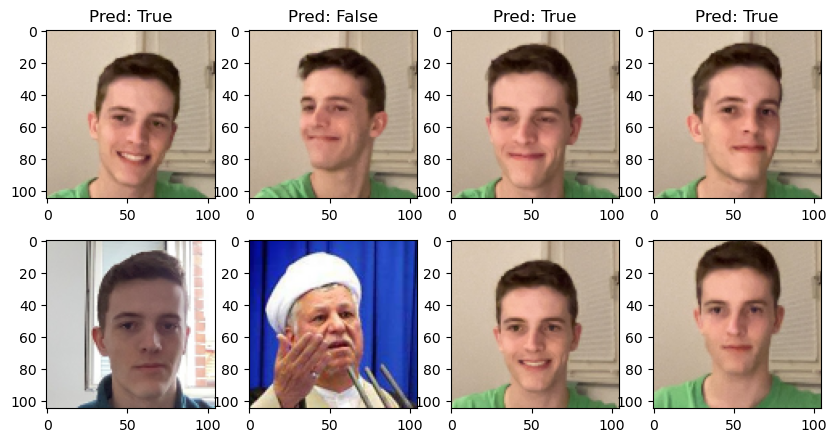

In [30]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 5))
for i in range(n_test):
    fig.add_subplot(2, n_test, i + 1)
    plt.imshow(test_data_1[i])
    plt.title(f"Pred: {bool(test_pred_bool[i])}")
for i in range(n_test):
    fig.add_subplot(2, n_test, i + 1 + n_test)
    plt.imshow(test_data_2[i])
plt.show()

#### Evaluation auf dem Gesamten Test-Datensatz

In [31]:
# Wiederholung: Accuracy beschreibt den Anteil richtiger Klassifizierungen an den gesamten Testdaten

 $accuracy = \frac{TP + TN}{TP + TN + FP + FN}$, TP = true positive,...

In [33]:
# Predictions aller Testdaten berechnen
pred = siamese_model_pre_trained.predict([test_data_1, test_data_2])
pred_bool = (pred > 0.5).astype(np.float32)

6/6 [==============================] - 11s 2s/step


In [34]:
# true positives und true negatives
tp_tn = len(test_data) - np.abs(test_label - pred_bool).sum()
accuracy = tp_tn / len(test_data)
print("Accuracy:", accuracy.round(4))

Accuracy: 1.0


### Details

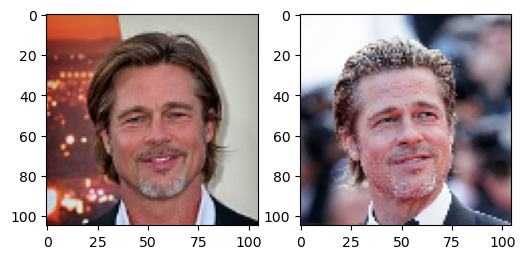

In [35]:
import image_generator
reload(image_generator)
from image_generator import read_image

fig = plt.figure(figsize=(6, 3))
#test_1 = test_data_1[2]
#test_2 = test_data_2[5]
test_1 = read_image("data/additional/Brad_Pitt_2019_by_Glenn_Francis.jpg")
#test_2 = test_1
test_2 = read_image("data/additional/3773139-2.jpg")
rand_lst = [test_1, test_2]
for i in range(len(rand_lst)):
    fig.add_subplot(1, len(rand_lst), i + 1)
    plt.imshow(rand_lst[i])
plt.show()

In [36]:
siamese_model_pre_trained.predict([test_1.reshape((1,IMG_SIZE,IMG_SIZE,3)), test_2.reshape((1,IMG_SIZE,IMG_SIZE,3))])

1/1 [==============================] - 1s 671ms/step


array([[0.99483407]], dtype=float32)

In [37]:
weights = siamese_model_pre_trained.layers[4].get_weights()[0]
bias = siamese_model_pre_trained.layers[4].get_weights()[1]
print("Bias in last layer:", bias[0])

Bias in last layer: 0.03501904


In [38]:
emb1 = embedding_pre_trained.predict(test_1.reshape((1,IMG_SIZE,IMG_SIZE,3)))
emb2 = embedding_pre_trained.predict(test_2.reshape((1,IMG_SIZE,IMG_SIZE,3)))

dist = L1Dist()(emb1, emb2)
dist.numpy()

1/1 [==============================] - 0s 10ms/step


2022-10-11 10:58:22.137605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.3040751 , 0.10398167, 0.26330727, ..., 0.01475732, 0.06221059,
        0.09120245]], dtype=float32)

In [39]:
tf.sigmoid(np.matmul(np.array(dist), weights) + bias).numpy()

array([[0.99483407]], dtype=float32)